In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm
from numba import njit
from scipy.stats import median_abs_deviation

import bayesflow as bf
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential

import sys
sys.path.append("../assets/")
from priors import sample_gamma, sample_eta, sample_random_walk
from likelihood import sample_non_stationary_diffusion_process
from context import generate_context
from configurations import approximator_settings    

## Model

$$
\begin{align}
x &\sim wiener(v_t, a_t, \tau_t, \beta) \\
v_t &= v_0 + b_{v, t} * \text{validity} \\
b_{v, t} &= \mathcal{T}(b_{v, 0:t-1}, \eta_v, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, \eta_v) \\
a_t &= \mathcal{T}(a_{0:t-1}, \eta_a, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, \eta_a) \\
\tau_t &= \tau_{0, t} + b_{\tau} * \text{face context} \\
\tau_{0, t} &= \mathcal{T}(\tau_{0, 0:t-1}, \eta_{\tau}, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, {\tau}) \\

\end{align}
$$


In [2]:
# scaled sigmod 
# prior predictive check accuracy plot
# remove base drift

### Parameter overview

**Global parameters $\eta$ (Static transition model parameters)**

$\eta = \{\eta_v, \eta_a, \eta_{\tau}\}$

**Local parameters $\theta_{1:T}$ (Time-varying DDM parameters)**

$\theta_{1:T} = \{b_{v, 1:T},  a_{1:T}, \tau_{1:T}\}$

**Shared parameters $\gamma$ (Static DDM parameters)**

$\gamma = \{v_0,  b_{\tau}, \beta\}$

## Constants

In [3]:
TRAIN_NETWORK = False
FIT_MODEL = False

In [4]:
NUM_OBS = 246
NUM_SAMPLES = 2000
NUM_RESIMULATIONS = 500

LOCAL_PARAM_LABELS = [
    'Sensitivity', 'Threshold', 'Non-decision time',
]
LOCAL_PARAM_NAMES  = [
    r'b_v', r'a', r'\tau_0'
]

GLOBAL_PARAM_LABELS = [
    'Baseline drift', 'Effect on NDT', 'Bias',
]
GLOBAL_PARAM_NAMES  = [
    r'$v_0$', r'$b_{\tau}$', r'$\beta$'
]

FONT_SIZE_1 = 28
FONT_SIZE_2 = 26
FONT_SIZE_3 = 24
FONT_SIZE_4 = 22

In [5]:
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

## Exemplar parameter trajectory

In [6]:
eta = sample_eta()
theta_t = sample_random_walk(eta)

In [ ]:
time = np.arange(theta_t.shape[0])
fig, axarr = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axarr.flat):
    if i == 7:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta_t[:, i],
        color='maroon'
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 4:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    if i > 3:
        ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

## Generative Model

In [ ]:
prior = bf.simulation.TwoLevelPrior(
    hyper_prior_fun=sample_eta,
    local_prior_fun=sample_random_walk,
    shared_prior_fun=sample_gamma
    )

context = bf.simulation.ContextGenerator(
    batchable_context_fun=generate_context,
    )

likelihood = bf.simulation.Simulator(
    simulator_fun=sample_non_stationary_diffusion_process,
    context_generator=context,
    )

model = bf.simulation.TwoLevelGenerativeModel(
    prior=prior,
    simulator=likelihood,
    name="random_walk_diffusion_model",
)

## Configurator

In [9]:
# N = 50000
# prior_samples = prior(N)

In [10]:
# HYPER_PRIOR_MEAN = np.round(prior_samples['hyper_parameters'].mean(axis=0), 2)
# HYPER_PRIOR_STD = np.round(prior_samples['hyper_parameters'].std(axis=0), 2)

# local_samples = prior_samples['local_parameters'].reshape(-1, prior_samples['local_parameters'].shape[-1])
# LOCAL_PRIOR_MEAN = np.round(local_samples.mean(axis=0), 2)
# LOCAL_PRIOR_STD = np.round(local_samples.std(axis=0), 2)

In [11]:
def configure_input(raw_dict):
    # prepare data
    data = raw_dict.get("sim_data")
    truth_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 0][:, :, None]
    face_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 1][:, :, None]
    validity_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 2][:, :, None]
    summary_conditions = np.c_[data, truth_context, to_categorical(face_context), validity_context]

    theta_t = raw_dict.get("local_prior_draws")
    eta = raw_dict.get("hyper_prior_draws")
    gamma = raw_dict.get("shared_prior_draws")

    # out_dict = dict(
    #     local_parameters=((theta_t - LOCAL_PRIOR_MEAN) / LOCAL_PRIOR_STD).astype(np.float32),
    #     hyper_parameters=((eta - HYPER_PRIOR_MEAN) / HYPER_PRIOR_STD).astype(np.float32),
    #     summary_conditions=summary_conditions.astype(np.float32),
    # )
    out_dict = dict(
        local_parameters=theta_t.astype(np.float32),
        hyper_parameters=eta.astype(np.float32),
        shared_parameters=gamma.astype(np.float32),
        summary_conditions=summary_conditions.astype(np.float32),
    )
    return out_dict

# Neural Approximator

In [12]:
summary_network = bf.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [13]:
local_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=3,
        **approximator_settings.get("local_amortizer_settings")
    )
)

global_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=3+3,
        **approximator_settings.get("global_amortizer_settings")
    )
)

In [ ]:
amortizer = bf.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/model_3"
)

# Training

In [ ]:
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=100,
        iterations_per_epoch=1000,
        batch_size=32
    )
    loss_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable())
else:
    loss_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable())

# Validation

# Application

## Fit to Empirical Data

In [37]:
data = pd.read_csv('../data/prepared_data.csv')
SUBJECTS = data.id.unique()
NUM_SUBJECTS = len(SUBJECTS)

In [17]:
if FIT_MODEL:
    local_post_samples = np.full((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3), np.nan)
    global_post_samples = np.full((NUM_SUBJECTS, NUM_SAMPLES, 6), np.nan)

    resim_data = np.full((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS, 7), np.nan)

    for i, id in enumerate(tqdm(SUBJECTS)):
        # model fitting
        person_data = data.loc[data.id == id]

        truth_context = person_data.correct_resp
        face_context = person_data.number_faces
        validity_context = person_data.validity

        resp = person_data.resp
        rt = person_data.rt
        mask = np.isfinite(rt)

        data_configured = np.c_[
            rt[mask], resp[mask], truth_context[mask],
            to_categorical(face_context[mask]), validity_context[mask]
        ][None, :, :].astype(np.float32)

        post_samples = amortizer.sample({'summary_conditions': data_configured}, n_samples=NUM_SAMPLES)

        local_post_samples[i, mask] = post_samples['local_samples']
        global_post_samples[i] = post_samples['global_samples']

        # posterior resimulation
        idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
        local_samples = post_samples['local_samples'][:, idx].astype(np.float32)
        global_samples = post_samples['global_samples'][idx, -3:].astype(np.float32)
        context = np.c_[truth_context[mask], face_context[mask], validity_context[mask]].astype(np.float32)
        sub_id = np.full((NUM_RESIMULATIONS, NUM_OBS), id)
        sim_seq = np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS).reshape((NUM_RESIMULATIONS, NUM_OBS))
        for j in range(NUM_RESIMULATIONS):
            x = sample_non_stationary_diffusion_process([local_samples[:, j], global_samples[j]], context)
            resim_data[i, j, mask, 2:] = np.c_[x, context]
        resim_data[i, :, :, 0] = sub_id
        resim_data[i, :, :, 1] = sim_seq

    np.save("../data/local_post_samples.npy", local_post_samples)
    np.save("../data/global_post_samples.npy", global_post_samples)
    np.save("../data/post_resim_data.npy", resim_data)
else:
    local_post_samples = np.load("../data/local_post_samples.npy")
    global_post_samples = np.load("../data/global_post_samples.npy")
    post_resim_data = np.load("../data/post_resim_data.npy")

## Parameter Trajectory

In [83]:
exp1_congruent_ids = data.id.loc[(data.exp == 1) & (data.condition == "congruent")].unique()
exp1_incongruent_ids = data.id.loc[(data.exp == 1) & (data.condition == "incongruent")].unique()
exp2_witness_congruent_ids = data.id.loc[(data.exp == 2) & (data.condition == "congruent") & (data.exp_type == "witness")].unique()
exp2_witness_incongruent_ids = data.id.loc[(data.exp == 2) & (data.condition == "incongruent") & (data.exp_type == "witness")].unique()
exp2_gambling_congruent_ids = data.id.loc[(data.exp == 2) & (data.condition == "congruent") & (data.exp_type == "gambling")].unique()
exp2_gambling_incongruent_ids = data.id.loc[(data.exp == 2) & (data.condition == "incongruent") & (data.exp_type == "gambling")].unique()

ids_per_condition = [
    exp1_congruent_ids, exp1_incongruent_ids,
    exp2_witness_congruent_ids, exp2_witness_incongruent_ids,
    exp2_gambling_congruent_ids, exp2_gambling_incongruent_ids
]

CONDITION_NAMES = [
    "Experiment 1 (witness)",
    "Experiment 2 (witness)",
    "Experiment 2 (gambling)"
]

local_post_per_condition = [
    local_post_samples[exp1_congruent_ids], local_post_samples[exp1_incongruent_ids],
    local_post_samples[exp2_witness_congruent_ids], local_post_samples[exp2_witness_incongruent_ids],
    local_post_samples[exp2_gambling_congruent_ids], local_post_samples[exp2_gambling_incongruent_ids]
]

shared_post_per_condition = [
    global_post_samples[exp1_congruent_ids, :, -3:], global_post_samples[exp1_incongruent_ids, :, -3:],
    global_post_samples[exp2_witness_congruent_ids, :, -3:], global_post_samples[exp2_witness_incongruent_ids, :, -3:],
    global_post_samples[exp2_gambling_congruent_ids, :, -3:], global_post_samples[exp2_gambling_incongruent_ids, :, -3:]
]

pred_data_per_condition = [
    post_resim_data[exp1_congruent_ids], post_resim_data[exp1_incongruent_ids], 
    post_resim_data[exp2_witness_congruent_ids], post_resim_data[exp2_witness_incongruent_ids], 
    post_resim_data[exp2_gambling_congruent_ids], post_resim_data[exp2_gambling_incongruent_ids],
]

In [84]:
# emp_data = np.full((NUM_SUBJECTS, NUM_OBS, 2), np.nan)
# for i in range(NUM_SUBJECTS):
#     person_data = data.loc[data.id == id]
#     rt = person_data.rt
#     correct = person_data.correct
#     mask = np.isfinite(rt)
#     emp_data[i, mask] = np.c_[rt[mask], correct[mask]]

# emp_data_per_condition = [
#     emp_data[exp1_congruent_ids], emp_data[exp1_incongruent_ids],
#     emp_data[exp2_witness_congruent_ids], emp_data[exp2_witness_incongruent_ids],
#     emp_data[exp2_gambling_congruent_ids], emp_data[exp2_gambling_incongruent_ids]
# ]

In [85]:
local_summary_per_condition = []
for i in range(len(local_post_per_condition)):
    local_means = np.nanmean(np.nanmedian(local_post_per_condition[i], axis=2), axis=0)
    local_stds = np.nanstd(np.nanmedian(local_post_per_condition[i], axis=2), axis=0)
    local_summary_per_condition.append(
        np.c_[local_means[:, :, None], local_stds[:, :, None]]
    )

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [ ]:
decrease_font = 10

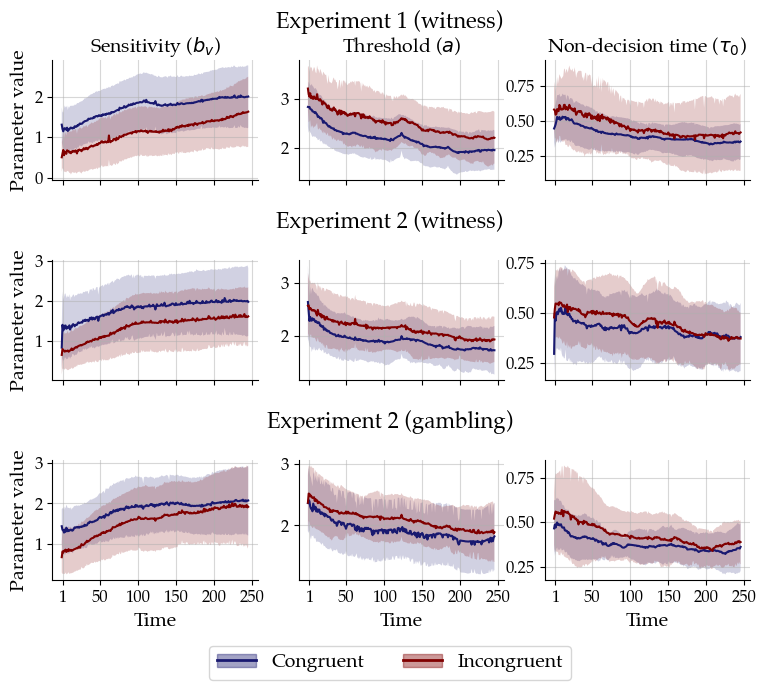

In [133]:
time = np.arange(local_summary_per_condition[0].shape[0])
fig = plt.figure(figsize=(9, 6))
# create 3x1 subfigs with equal height ratios
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(CONDITION_NAMES[row], fontsize=FONT_SIZE_1 - decrease_font, fontweight='bold', y=1.1)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.plot(
            time, local_summary_per_condition[2*row][:, col, 0],
            color='midnightblue',
            label='Average posterior median (congruent)',
            lw=1.5
        )
        
        ax.fill_between(
            time,
            local_summary_per_condition[2*row][:, col, 0] - local_summary_per_condition[2*row][:, col, 1],
            local_summary_per_condition[2*row][:, col, 0] + local_summary_per_condition[2*row][:, col, 1],
            alpha=0.2,
            color='midnightblue',
            label="Std. dev. posterior median (congruent)",
            edgecolor=None
        )
        ax.plot(
            time, local_summary_per_condition[2*row+1][:, col, 0],
            color='maroon',
            label='Average posterior median (incongruent)',
            lw=1.5
        )
        
        ax.fill_between(
            time,
            local_summary_per_condition[2*row+1][:, col, 0] - local_summary_per_condition[2*row+1][:, col, 1],
            local_summary_per_condition[2*row+1][:, col, 0] + local_summary_per_condition[2*row+1][:, col, 1],
            alpha=0.2,
            color='maroon',
            label="Std. dev. posterior median (incongruent)",
            edgecolor=None
        )
        ax.grid(alpha=0.5)
        if row == 0:
            ax.set_title(f'{LOCAL_PARAM_LABELS[col]} (${LOCAL_PARAM_NAMES[col]}$)', fontsize=FONT_SIZE_2 - decrease_font)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3 - decrease_font)
        ax.set_xticks([1, 50, 100, 150, 200, 250])
        if col == 0:
            ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2 - decrease_font)
        if row == 2:
            ax.set_xlabel("Time", fontsize=FONT_SIZE_2 - decrease_font)
        else:
            ax.set_xticklabels([])

# Create custom legend handles
handles = [
    (Line2D([], [], color='midnightblue', lw=2), Patch(color='midnightblue', alpha=0.4)),
    (Line2D([], [], color='maroon', lw=2), Patch(color='maroon', alpha=0.4))
]

# Adjust layout to make space for the legend
fig.subplots_adjust(bottom=0.25, hspace=2, wspace=0.2, top=0.85)

fig.legend(
    handles=handles,
    labels=['Congruent', 'Incongruent'],
    fontsize=FONT_SIZE_2 - decrease_font, bbox_to_anchor=(0.5, -0.01),
    loc="upper center", ncol=2
)

sns.despine()
fig.savefig(
    "../plots/average_param_trajectory.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True
    )

## Shared Parameters

In [110]:
OFFSET = 0.1
Y_VALUES = np.arange(3)

In [111]:
mean_shared_post_congruent = np.zeros((3, 3))
std_shared_post_congruent = np.zeros((3, 3))
mean_shared_post_incongruent = np.zeros((3, 3))
std_shared_post_incongruent = np.zeros((3, 3))
counter = 0
for i, array in enumerate(shared_post_per_condition):
    if i % 2 == 0:
        mean_shared_post_congruent[counter] = np.nanmedian(array, axis=1).mean(axis=0)
        std_shared_post_congruent[counter] = np.nanmedian(array, axis=1).std(axis=0)
    else:
        mean_shared_post_incongruent[counter] = np.nanmedian(array, axis=1).mean(axis=0)
        std_shared_post_incongruent[counter] = np.nanmedian(array, axis=1).std(axis=0)
        counter += 1

In [112]:
condition_names_rev = [
    'Experiment 2 (gambling)',
    'Experiment 2 (witness)',
    'Experiment 1 (witness)'
]

In [134]:
decrease_font = 12

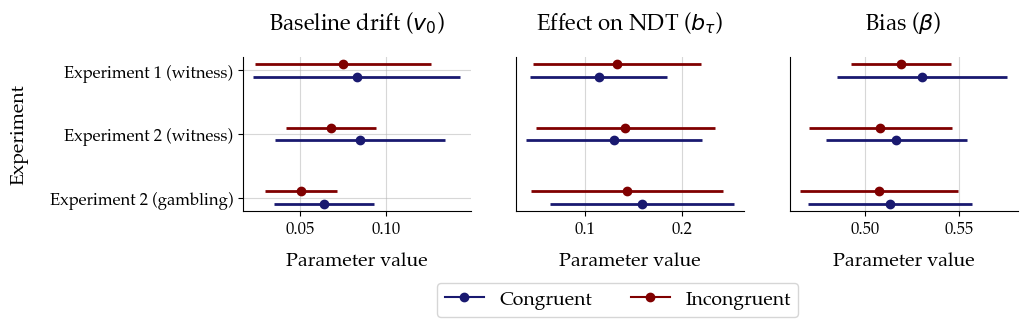

In [135]:
fig = plt.figure(figsize=(10, 2))
axs = fig.subplots(nrows=1, ncols=3)
for i, ax in enumerate(axs):
    ax.errorbar(
        mean_shared_post_congruent[:, i],
        Y_VALUES - OFFSET,
        xerr=std_shared_post_congruent[:, i],
        fmt='o', color='midnightblue', label='Congruent', alpha=1,
        markersize=6, elinewidth=2
    )
    ax.errorbar(
        mean_shared_post_incongruent[:, i],
        Y_VALUES + OFFSET,
        xerr=std_shared_post_incongruent[:, i],
        fmt='o', color='maroon', label='Incongruent', alpha=1,
        markersize=6, elinewidth=2
    )

    ax.grid(alpha=0.5)
    ax.set_title(f'{GLOBAL_PARAM_LABELS[i]} ({GLOBAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1 - decrease_font, pad=20)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3 - decrease_font)
    
    if i == 0:
        ax.set_ylabel("Experiment", fontsize=FONT_SIZE_2 - decrease_font, labelpad=15)
        ax.set_yticks(Y_VALUES, labels=condition_names_rev)
    else:
        ax.set_ylabel("", fontsize=FONT_SIZE_2 - decrease_font, labelpad=10)
        ax.set_yticks([])
    ax.set_xlabel("Parameter value", fontsize=FONT_SIZE_2 - decrease_font, labelpad=10)

    sns.despine()

# Adjust layout to make space for the legend
# fig.subplots_adjust(bottom=0.2, hspace=0.5, wspace=0.3, top=0.85)

# Create custom legend handles
handles = [
    Line2D([0], [0], color='midnightblue', marker='o', markersize=6, linestyle='-', linewidth=1.5, label='Congruent'),
    Line2D([0], [0], color='maroon', marker='o', markersize=6, linestyle='-', linewidth=1.5, label='Incongruent')
]

fig.legend(
    handles=handles,
    labels=['Congruent', 'Incongruent'],
    fontsize=FONT_SIZE_2 - decrease_font, bbox_to_anchor=(0.5, -0.2),
    loc="upper center", ncol=2
)

fig.savefig(
    "../plots/average_global_parameter.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

## Posterior Re-simulation

In [138]:
emp_df_per_condition = []
for ids in ids_per_condition:
    emp_df_per_condition.append(
        data.loc[data["id"].isin(ids), ("condition", "id", "resp", "correct", "correct_resp", "number_faces", "validity", "rt")]
    )

In [139]:
pred_df_per_condition = []
for data in pred_data_per_condition:
    reshaped_data = data.reshape(-1, 7)
    resim_df = pd.DataFrame(reshaped_data, columns=['id', 'sim', 'rt', 'resp', 'correct', 'number_faces', 'validity'])
    resim_df["correct"] = np.where(resim_df["resp"] == resim_df["correct"], 1, 0)
    pred_df_per_condition.append(resim_df)

In [140]:
pred_summaries_per_condition = []
for pred_data in pred_df_per_condition:
    grouped_data = pred_data.groupby(['id', 'validity'])
    resim_summaries = grouped_data.agg({
                'rt': ['median'],
                'correct': ['mean']
            }).reset_index(drop=False)
    resim_summaries.columns = ['id', "validity", 'rt_median', 'acc']

    grouped_data = resim_summaries.groupby(['validity'])
    resim_summaries = grouped_data.agg({
                'rt_median': ['mean', 'std'],
                'acc': ['mean', 'std']
            }).reset_index(drop=False)
    resim_summaries.columns = ["validity", 'avg_rt_median', 'std_rt_median', 'avg_acc', 'std_acc']
    pred_summaries_per_condition.append(resim_summaries)

In [141]:
emp_summaries_per_condition = []
for emp_df in emp_df_per_condition:
    grouped_data = emp_df.groupby(['id', 'validity'])
    empiric_summaries = grouped_data.agg({
                'rt': ['median'],
                'correct': ['mean']
            }).reset_index(drop=False)
    empiric_summaries.columns = ['id', "validity", 'rt_median', 'acc']

    grouped_data = empiric_summaries.groupby(['validity'])
    empiric_summaries = grouped_data.agg({
                'rt_median': ['mean', 'std'],
                'acc': ['mean', 'std']
            }).reset_index(drop=False)
    empiric_summaries.columns = ["validity", 'avg_rt_median', 'std_rt_median', 'avg_acc', 'std_acc']
    emp_summaries_per_condition.append(empiric_summaries)

In [142]:
summaries = [emp_summaries_per_condition, pred_summaries_per_condition]

ESCAPE = [-0.2, 0.2]
X_AXIS_VALUES = np.arange(8) * 1.5
COLOR = ['black', 'maroon']

LABELS = ["Observed", "Re-simulated"]
SUBTITLES = ["Congruent", "Incongruent"]

## Response Times

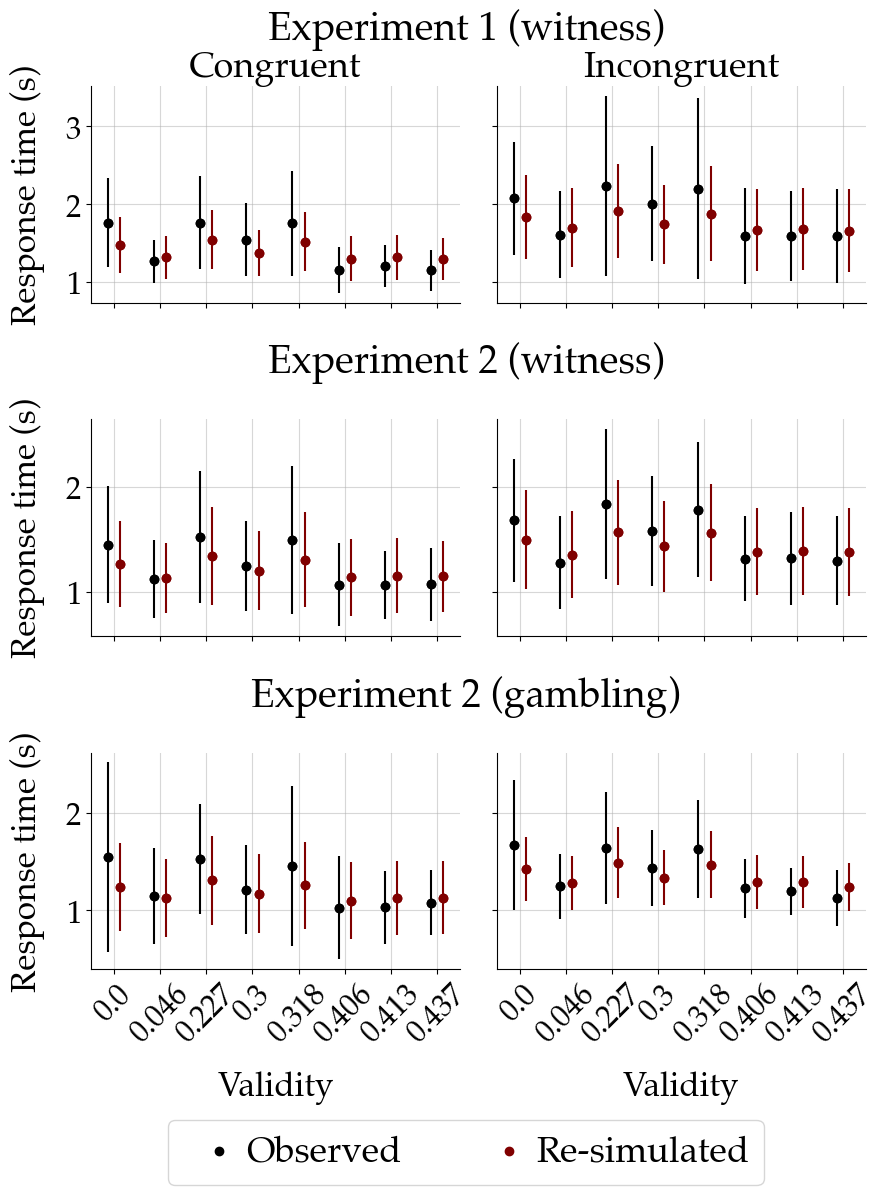

In [152]:
fig = plt.figure(figsize=(10, 10))
# create 3x1 subfigs with gridspec_kw to adjust spacing
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(CONDITION_NAMES[row], fontsize=FONT_SIZE_1, fontweight='bold')
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)
    for col, ax in enumerate(axs):
        for j in range(2):
            ax.scatter(
                X_AXIS_VALUES + ESCAPE[j],
                summaries[j][col+2*row]['avg_rt_median'],
                color=COLOR[j], label=LABELS[j]
            )
            ax.errorbar(
                X_AXIS_VALUES + ESCAPE[j],
                summaries[j][col+2*row]['avg_rt_median'],
                summaries[j][col+2*row]['std_rt_median'],
                fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
            )
            ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity'].unique().round(decimals=3), rotation=45)
        if row == 0:
            ax.set_title(f'{SUBTITLES[col]}', fontsize=FONT_SIZE_2)
        if row == 2:
            ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_3)
        else:
            ax.set_xticklabels([])
        if col == 0:
            ax.set_ylabel("Response time (s)", labelpad=15, fontsize=FONT_SIZE_3)
        if row == 0 and col == 0:
            fig.legend(
                fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.15),
                loc="center", ncol=2, handletextpad=-0.25
            )
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_4)
        ax.grid(alpha=0.5)

# Adjust layout to make space for the legend
fig.subplots_adjust(bottom=0.1, hspace=1, wspace=0.1, top=0.75)

sns.despine()
fig.savefig(
    "../plots/post_resim_rt.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

## Accuracy

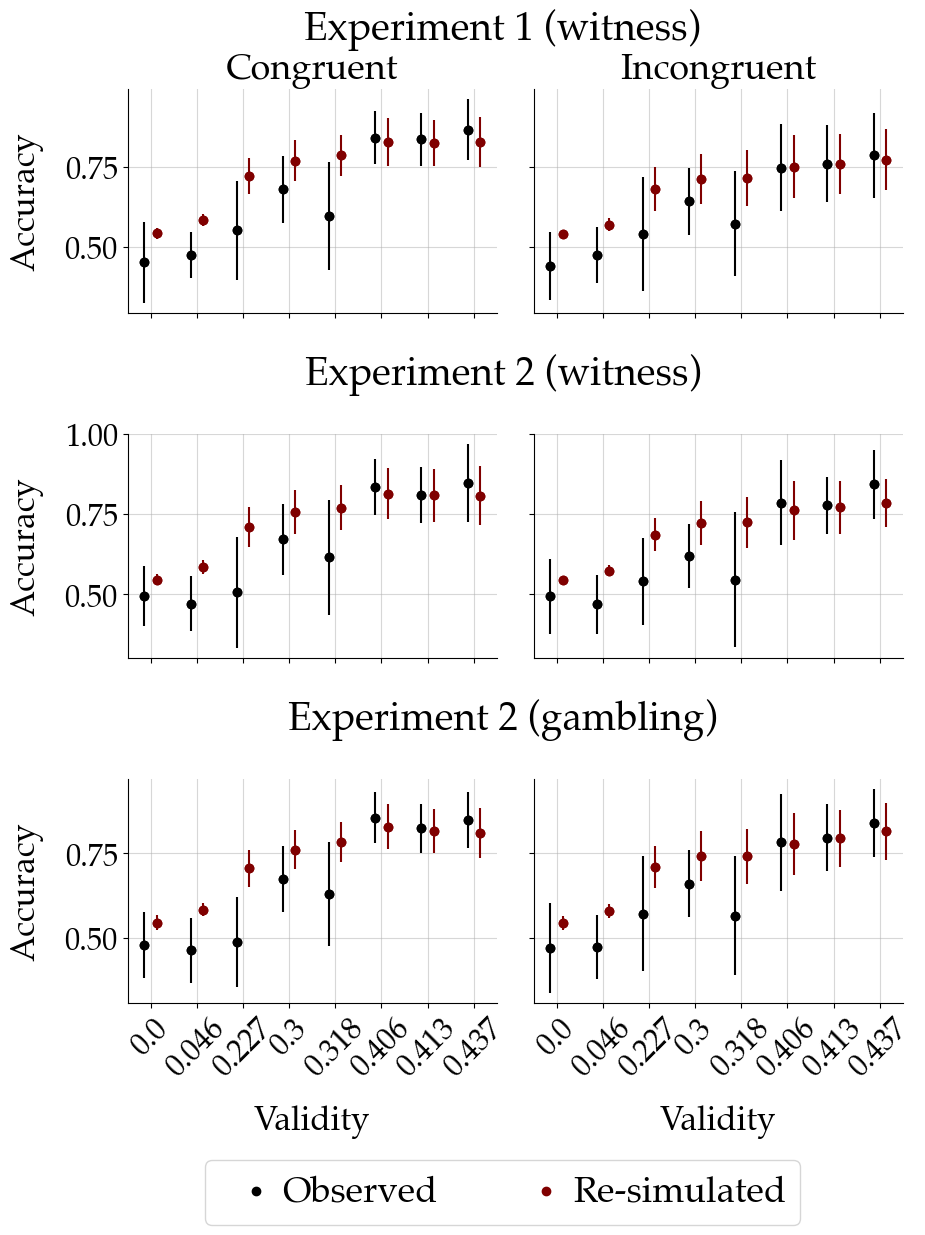

In [157]:
fig = plt.figure(figsize=(10, 10.35))
# create 3x1 subfigs with gridspec_kw to adjust spacing
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(CONDITION_NAMES[row], fontsize=FONT_SIZE_1, fontweight='bold')
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)
    for col, ax in enumerate(axs):
        for j in range(2):
            ax.scatter(
                X_AXIS_VALUES + ESCAPE[j],
                summaries[j][col+2*row]['avg_acc'],
                color=COLOR[j], label=LABELS[j]
            )
            ax.errorbar(
                X_AXIS_VALUES + ESCAPE[j],
                summaries[j][col+2*row]['avg_acc'],
                summaries[j][col+2*row]['std_acc'],
                fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
            )
            ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity'].unique().round(decimals=3), rotation=45)
        if row == 0:
            ax.set_title(f'{SUBTITLES[col]}', fontsize=FONT_SIZE_2)
        if row == 2:
            ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_3)
        else:
            ax.set_xticklabels([])
        if col == 0:
            ax.set_ylabel("Accuracy", labelpad=15, fontsize=FONT_SIZE_3)
        if row == 0 and col == 0:
            fig.legend(
                fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.15),
                loc="center", ncol=2, handletextpad=-0.25
            )
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_4)
        ax.grid(alpha=0.5)

# Adjust layout to make space for the legend
fig.subplots_adjust(bottom=0.1, hspace=1, wspace=0.1, top=0.75)


sns.despine()
fig.savefig(
    "../plots/post_resim_accuracy.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

## Simple Moving Average Time series

In [34]:
def get_sma(data, window_size):
    if window_size < 1:
        raise ValueError("Window size must be at least 1")

    sma = np.full(len(data), np.nan)
    for i in range(window_size - 1, len(data)):
        sma[i] = np.nanmean(data[i - window_size + 1:i + 1])
    
    return sma

In [ ]:
TIME_WINDOW = 20

### Response Times

In [56]:
emp_rt_sma_per_condition = np.full((6, NUM_OBS, 2), np.nan)
pred_rt_sma_per_condition = np.full((6, NUM_OBS, 2), np.nan)
for i, emp_df in enumerate(emp_df_per_condition):
    emp_rt_sma = np.full((emp_df.id.unique().shape[0], NUM_OBS), np.nan)
    pred_rt_sma = np.full((emp_df.id.unique().shape[0], NUM_RESIMULATIONS, NUM_OBS), np.nan)
    # empirical
    for j, id in tqdm(enumerate(emp_df.id.unique())):
        emp_rt_sma[j] = get_sma(emp_df.loc[emp_df.id == id].rt, TIME_WINDOW)
        # predicted
        tmp_pred_data = pred_df_per_condition[i]
        person_pred_data = tmp_pred_data.loc[tmp_pred_data.id == id].rt.to_numpy().reshape(NUM_RESIMULATIONS, NUM_OBS)
        for p in range(NUM_RESIMULATIONS):
            pred_rt_sma[j, p] = get_sma(person_pred_data[i], TIME_WINDOW)
    pred_rt_sma_median = np.nanmedian(pred_rt_sma, axis=1) 
    pred_rt_sma_per_condition[i, :, 0] = np.nanmean(pred_rt_sma_median, axis=0)
    pred_rt_sma_per_condition[i, :, 1] = np.nanstd(pred_rt_sma_median, axis=0)

    emp_rt_sma_per_condition[i, :, 0] = np.nanmean(emp_rt_sma, axis=0)
    emp_rt_sma_per_condition[i, :, 1] = np.nanstd(emp_rt_sma, axis=0)

48it [00:38,  1.25it/s]
/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_22107/540686207.py:14: RuntimeWarning: All-NaN slice encountered
  pred_rt_sma_median = np.nanmedian(pred_rt_sma, axis=1)
/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_22107/540686207.py:15: RuntimeWarning: Mean of empty slice
  pred_rt_sma_per_condition[i, :, 0] = np.nanmean(pred_rt_sma_median, axis=0)
/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_22107/540686207.py:18: RuntimeWarning: Mean of empty slice
  emp_rt_sma_per_condition[i, :, 0] = np.nanmean(emp_rt_sma, axis=0)
50it [00:40,  1.24it/s]
42it [00:33,  1.24it/s]
37it [00:30,  1.23it/s]
40it [00:32,  1.25it/s]
15it [00:12,  1.24it/s]/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_22107/3855161591.py:

### Accuracy

In [51]:
emp_acc_sma_per_condition = np.full((6, NUM_OBS, 2), np.nan)
pred_acc_sma_per_condition = np.full((6, NUM_OBS, 2), np.nan)
for i, emp_df in enumerate(emp_df_per_condition):
    emp_acc_sma = np.full((emp_df.id.unique().shape[0], NUM_OBS), np.nan)
    pred_acc_sma = np.full((emp_df.id.unique().shape[0], NUM_RESIMULATIONS, NUM_OBS), np.nan)
    # empirical
    for j, id in tqdm(enumerate(emp_df.id.unique())):
        emp_acc_sma[j] = get_sma(emp_df.loc[emp_df.id == id].correct, TIME_WINDOW)
        # predicted
        tmp_pred_data = pred_df_per_condition[i]
        person_pred_data = tmp_pred_data.loc[tmp_pred_data.id == id].correct.to_numpy().reshape(NUM_RESIMULATIONS, NUM_OBS)
        for p in range(NUM_RESIMULATIONS):
            pred_acc_sma[j, p] = get_sma(person_pred_data[i], TIME_WINDOW)
    pred_acc_sma_median = np.nanmedian(pred_acc_sma, axis=1) 
    pred_acc_sma_per_condition[i, :, 0] = np.nanmean(pred_acc_sma_median, axis=0)
    pred_acc_sma_per_condition[i, :, 1] = np.nanstd(pred_acc_sma_median, axis=0)

    emp_acc_sma_per_condition[i, :, 0] = np.nanmean(emp_acc_sma, axis=0)
    emp_acc_sma_per_condition[i, :, 1] = np.nanstd(emp_acc_sma, axis=0)

48it [00:13,  3.56it/s]
/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_22107/2156056069.py:14: RuntimeWarning: All-NaN slice encountered
  pred_acc_sma_median = np.nanmedian(pred_acc_sma, axis=1)
/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_22107/2156056069.py:15: RuntimeWarning: Mean of empty slice
  pred_acc_sma_per_condition[i, :, 0] = np.nanmean(pred_acc_sma_median, axis=0)
/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_22107/2156056069.py:18: RuntimeWarning: Mean of empty slice
  emp_acc_sma_per_condition[i, :, 0] = np.nanmean(emp_acc_sma, axis=0)
50it [00:14,  3.54it/s]
42it [00:11,  3.60it/s]
37it [00:10,  3.61it/s]
40it [00:11,  3.62it/s]
41it [00:11,  3.65it/s]


In [61]:
COLUMN_NAMES = ["Accuracy", "Response time"]
emp_plotting_data = [emp_acc_sma_per_condition, emp_rt_sma_per_condition]

In [136]:
decrease_font = 10

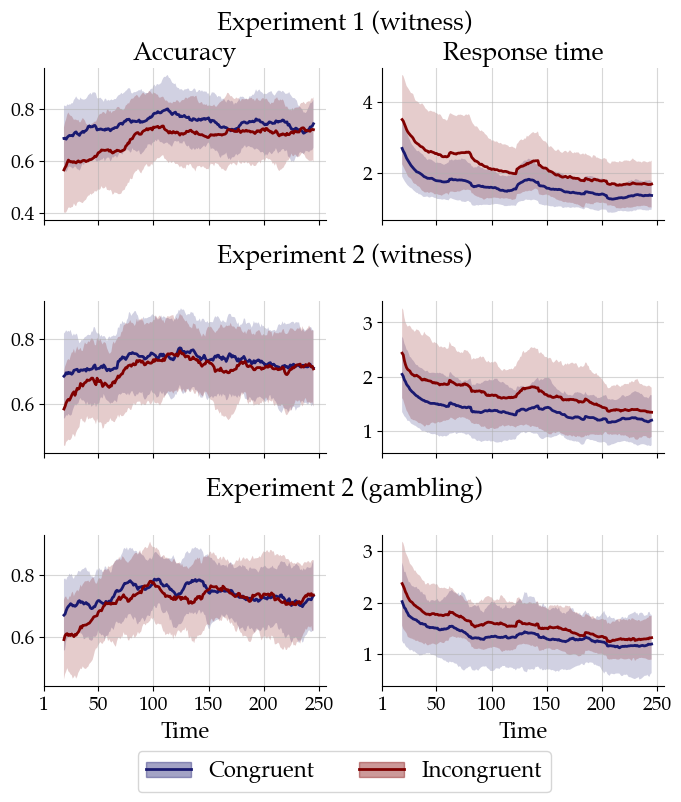

In [158]:
time = np.arange(NUM_OBS)
fig = plt.figure(figsize=(8, 7))
# create 3x1 subfigs with equal height ratios
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(CONDITION_NAMES[row], fontsize=FONT_SIZE_1-decrease_font, fontweight='bold', y=1.1)
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        ax.plot(
            emp_plotting_data[col][2*row, :, 0],
            color='midnightblue', label='Congruent', lw=2
        )
        ax.fill_between(
            np.arange(NUM_OBS),
            emp_plotting_data[col][2*row, :, 0] - emp_plotting_data[col][2*row, :, 1],
            emp_plotting_data[col][2*row, :, 0] + emp_plotting_data[col][2*row, :, 1],
            color='midnightblue', alpha=0.2, edgecolor=None
        )
        # incongruent
        ax.plot(
            emp_plotting_data[col][2*row+1, :, 0],
            color='maroon', label='Incongruent', lw=2
        )
        ax.fill_between(
            np.arange(NUM_OBS),
            emp_plotting_data[col][2*row+1, :, 0] - emp_plotting_data[col][2*row+1, :, 1],
            emp_plotting_data[col][2*row+1, :, 0] + emp_plotting_data[col][2*row+1, :, 1],
            color='maroon', alpha=0.2, edgecolor=None
        )
        ax.grid(alpha=0.5)
        if row == 0:
            ax.set_title(COLUMN_NAMES[col], fontsize=FONT_SIZE_1-decrease_font)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3-decrease_font)
        ax.set_xticks([1, 50, 100, 150, 200, 250])
        ax.set_ylabel("", fontsize=FONT_SIZE_2-decrease_font)
        if row == 2:
            ax.set_xlabel("Time", fontsize=FONT_SIZE_2-decrease_font)
        else:
            ax.set_xticklabels([])

# Create custom legend handles
handles = [
    (Line2D([], [], color='midnightblue', lw=2), Patch(color='midnightblue', alpha=0.4)),
    (Line2D([], [], color='maroon', lw=2), Patch(color='maroon', alpha=0.4))
]

# Adjust layout to make space for the legend
fig.subplots_adjust(bottom=0.2, hspace=2, wspace=0.2, top=0.85)

fig.legend(
    handles=handles,
    labels=['Congruent', 'Incongruent'],
    fontsize=FONT_SIZE_2-decrease_font, bbox_to_anchor=(0.5, -0.01),
    loc="upper center", ncol=2
)

sns.despine()

fig.savefig(
    "../plots/emp_data_time_series.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True
)